<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/model_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise Sheet 6 – Natural Language Processing with BERT

* Deep Learning
 * Instructor: Alexander Ecker
 * Tutors: Max Burg, Laura Pede
 * Due date: **Tue, Feb 1, noon**
 



### IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient

## Useful information: lecture schedule and exercise sheet deadline

The topics you will need to solve in this exercise sheet may not have been discussed in the lecture at the time we handed out this notebook. We kept the exercises rather short so you can solve them in one week and recommend that you wait until all topics have been introduced in the lecture. If you want to start right away, here are some resources that might be helpful:

- https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
- https://jalammar.github.io/illustrated-transformer/
- https://jalammar.github.io/illustrated-bert/
- https://huggingface.co/transformers/glossary.html (Glossary)

The articles that are linked in those blog posts are nice resources on background information as well.

(Figures and some explanaitions are based on the work of Jay Alammar, jalammar.github.io)

# Setup and Dataset


## Using Colab GPU for Training 

A GPU can be added by going to the menu and selecting 


```
Edit --> Notebook Settings --> Hardware accelerator --> (GPU)
```



In [2]:
import torch

# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
    device = torch.device("cuda")
    print('There is/are %d GPU(s) available.' % torch.cuda.device_count())
    print()
    print("We will use the GPU: ", torch.cuda.get_device_name(0))
    print("with the following properties: ")
    print(torch.cuda.get_device_properties(0))
else:
    print('No GPU available, training on CPU instead.')

Training on GPU.
There is/are 1 GPU(s) available.

We will use the GPU:  Tesla P100-PCIE-16GB
with the following properties: 
_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


## Installing the Hugging Face library 

 Next, let’s install the [transformers package from the Hugging Face library](https://huggingface.co/transformers/index.html) which will give us a Pytorch interface for working with implementations of state-of-the-art embedding layers. This library contains interfaces for  pretrained language models like BERT, XLNet, OpenAI’s GPT.


In [1]:
%%capture
!pip install transformers
!pip install requests
!pip install captum


# Sentiment Analysis

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from captum.attr import visualization

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Pre-processing

In [4]:
# load the training data
file_name = "/content/drive/MyDrive/Colab/airbnb/data/data1/listings_workfile.pickle"
data = pd.read_pickle(file_name)
reviews, labels = data['reviews'].to_numpy(), data['log_price'].to_numpy()

In [5]:
nreviews = np.vectorize(len)(reviews)

In [6]:
reviews = np.concatenate(reviews)
labels = np.repeat(labels, nreviews)

### Explore the dataset

In [7]:
# TODO show the first 10 samples together
# with their label (positive or negative review)
import pandas as pd
pd.DataFrame(np.hstack([labels[0:10].reshape(10,1), reviews[0:10].reshape(10,1)]))


,0,1
0,4.787491742782046,The stay with Eva was to my full satisfaction....
1,4.787491742782046,A very nice accommodation in a private large h...
2,4.787491742782046,Eva's The Rooms offers a wonderful opportunity...
3,4.787491742782046,"If you need a clean, comfortable place to stay..."
4,4.787491742782046,Great B&B close to Alte Donau with lots of swi...
5,4.787491742782046,very good located rooms. we had a nice time in...
6,4.787491742782046,"Breakfast was the best part of the stay, place..."
7,4.787491742782046,"Eva was a great host, very responsive and extr..."
8,4.787491742782046,Eva has created a unique and beautiful Bed and...
9,4.787491742782046,Eva's place is the perfect place to stay while...


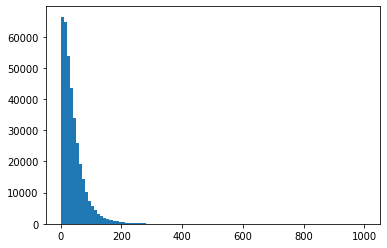

In [8]:
# TODO Visualize the length of the reviews in your dataset
def count_words(string):
    return len(string.split())

review_lengths = np.vectorize(count_words)(reviews)

a = plt.hist(review_lengths, bins = 100)
plt.show()

## BERT: tokenization & input formatting

We will use the excellent [transformers package from the Hugging Face library](https://huggingface.co/transformers/index.html) to work with BERT.

The first step is to tokenize the reviews and bring them into the format that BERT expects. This includes

- Tokenization: break words up into words and subwords in the format BERT was trained with
- Adding special tokens: [CLS], [SEP]
- Trimming sentences to maximum length
- Padding [PAD] shorter sentences. We want BERT to process our examples batch-wise. Hence, we need to pad all lists to the same size, so we can represent the input as one 2-d array.

Documentation of `BertTokenizer`: https://huggingface.co/transformers/model_doc/bert.html#berttokenizer

In [9]:
# Get rid of Colab warning about Tensorflow versions
%tensorflow_version 1.x

from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading the BERT tokenizer...')

# We will use bert-base-uncased model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

TensorFlow 1.x selected.
Loading the BERT tokenizer...


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
tokenizer(list(reviews[0:100]))

{'input_ids': [[101, 1996, 2994, 2007, 9345, 2001, 2000, 2026, 2440, 9967, 1012, 1996, 4807, 2001, 3565, 5379, 1998, 9345, 2001, 2800, 2012, 2151, 2051, 1998, 2016, 5838, 20877, 2102, 2000, 2739, 1012, 1996, 11366, 2003, 2284, 1037, 2261, 4534, 2013, 1996, 2364, 2346, 1010, 2061, 2045, 2003, 2053, 2395, 5005, 1998, 2489, 5581, 1999, 2392, 1997, 1996, 2341, 1012, 1996, 2282, 2001, 3599, 2004, 2649, 1012, 6350, 2001, 9426, 1998, 2062, 2084, 7182, 1012, 1045, 2052, 5791, 2272, 2067, 1012, 102], [101, 1037, 2200, 3835, 11366, 1999, 1037, 2797, 2312, 2160, 2007, 2200, 3835, 6184, 1012, 2057, 2371, 2200, 6625, 1012, 1996, 2282, 2003, 6298, 3973, 2881, 1998, 2038, 2673, 2017, 2342, 1012, 3811, 6749, 999, 102], [101, 9345, 1005, 1055, 1996, 4734, 4107, 1037, 6919, 4495, 2000, 2994, 1999, 6004, 1999, 1037, 4251, 2181, 1998, 2707, 2013, 2045, 2006, 26144, 2015, 2000, 1996, 2103, 2030, 11301, 1012, 1996, 2282, 2001, 26931, 1998, 14258, 19851, 1010, 1996, 6350, 12090, 1010, 1996, 4807, 2307, 999, 

In [11]:
# Maximum length of a sequence
MAX_LEN = 128

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []

# Create attention masks
attention_masks = []

# For every sentence...
for review in tqdm(reviews):
  
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad to maximum length if the sequence is shorter
    sequence = tokenizer.encode_plus(
                    review,                      # Review to encode.
                    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                    truncation=True,
                    max_length=MAX_LEN,
                    padding='max_length',
                    return_attention_mask=True)
    input_ids.append(sequence['input_ids'])
    attention_masks.append(sequence['attention_mask'])

input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)

100%|██████████| 364781/364781 [07:34<00:00, 802.65it/s] 


In [12]:
path = "/content/drive/MyDrive/Colab/airbnb/data/reviews/input_ids.npy"
np.save(path, input_ids)
path = "/content/drive/MyDrive/Colab/airbnb/data/reviews/labels.npy"
np.save(path, labels)
path = "/content/drive/MyDrive/Colab/airbnb/data/reviews/attention_masks.npy"
np.save(path, attention_masks)

In [13]:
from re import T
# TODO
# Print the 25th (index 24 as indexing starts with 0 in python) example sentence
# 1) as original, 
print(reviews[24])
# 2) list of token IDs, 
print(input_ids[24])
# 3) it's attention mask,
print(attention_masks[24])
# 4) the human readable string recreated from the token IDs, and
print(tokenizer.decode(input_ids[24]))
# 5) the human readable, recreated string with its according attention mask applied
print(tokenizer.decode(input_ids[24][attention_masks[24].astype("bool")]))


We were there for the second time and had wonderful days in Vienna again. Hannes is a perfect host who welcomed us very warmly. Check-in and check-out is uncomplicated and works perfectly. The highlights were again this time the place in the yard, where we had breakfast in the open air in the morning and enjoyed a glass of wine in the evening as well as the Danube Canal, which can be reached in a few minutes on foot. Meanwhile we feel almost at home in the cozy and well equipped apartment and in the Leopoldstadt and come back gladly.
[  101  2057  2020  2045  2005  1996  2117  2051  1998  2018  6919  2420
  1999  6004  2153  1012  7658  5267  2003  1037  3819  3677  2040 10979
  2149  2200 22775  1012  4638  1011  1999  1998  4638  1011  2041  2003
  4895  9006 24759 17872  1998  2573  6669  1012  1996 11637  2020  2153
  2023  2051  1996  2173  1999  1996  4220  1010  2073  2057  2018  6350
  1999  1996  2330  2250  1999  1996  2851  1998  5632  1037  3221  1997
  4511  1999  1996  39

## Training, Validation, Test Split

Use 10% of the dataset as validation and test set, respectively. Use the other 80% for training.

In [4]:
root = "/content/drive/MyDrive/Colab/airbnb/data/reviews/"
attention_masks = np.load(root + "attention_masks.npy")
input_ids = np.load(root + "input_ids.npy")
labels = np.load(root + "labels.npy")

In [6]:
# TODO: Split data into training, validation, and test data
# (features, labels, and attention masks)
#input_ids, _, labels, _, attention_masks, _ = train_test_split(input_ids, labels, attention_masks, train_size=0.1, random_state=42)
tmp = train_test_split(input_ids, labels, attention_masks, train_size=0.8, random_state=42)
ids_train, ids_val, labels_train, labels_val, masks_train, masks_val = tmp

In [7]:
# TODO: Print out the shapes of your splitted train, validation, and test set
# Hint: your validation set should contain 500 samples. How many tokens are
# included per sample? 

# (1) print the feature shapes
print(ids_train.shape)
print(ids_val.shape)

# (2) print the label shapes
print(labels_train.shape)
print(labels_val.shape)

# (3) print the attention mask shapes
print(masks_train.shape)
print(masks_val.shape)


(291824, 128)
(72957, 128)
(291824, 128)
(72957, 128)
(291824, 128)
(72957, 128)


## Create DataLoader

You can use `TensorDataset`, `torch.from_numpy(...)`, and `DataLoader(...)` to create Dataloaders for your dataset holding features, labels and attention masks. Make sure to shuffle your training data. Is shuffling required for the validation and test data?

In [8]:
# TODO
# create dataloaders
from torch.utils.data import TensorDataset, DataLoader
trainset = TensorDataset(torch.from_numpy(ids_train), torch.from_numpy(labels_train), torch.from_numpy(masks_train))
valset = TensorDataset(torch.from_numpy(ids_val), torch.from_numpy(labels_val), torch.from_numpy(masks_val))

b = 128
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)


# Sentiment analysis - classification model

We will build a sentiment classifier estimating if a review is positive or negative by using transfer learning from a pre-trained BERT model, adding a readout network to BERT's sentence embeddings. For that task, we do not use the whole sentence embedding space, but only the subspace corresponding to the classification (`[CLS]`) token, including all of the 768 hidden units.



### Build the model

#### TODO


- Load a pre-trained BERT model. A good starting point for more information is the quickstart guide of the transformers library: https://huggingface.co/transformers/quickstart.html . 
- Make sure to implement the possibility to use attention masks as well. 
- Slice BERT's sentence embedding space as described above (we only want to use the `[CLS]` token for classification)
- Add two fully connected layers to that sentence embedding subspace. 
  - The first fully connected layer should have 768 output units, followed by ReLU activation function. 
  - The second (and last) fully connected layer acts as a binary classifier on top, mapping a `(BATCH_SIZE x 768)` tensor onto `(BATCH_SIZE, 2)` to predict the two classes, encoded by a one-hot vector.


*Hints:*
- Note that we used the `'bert-base-uncased'` model in the tokenizer. Use the same model here. For more information, check https://huggingface.co/transformers/pretrained_models.html
- Loading the BERT model with pre-trained model weights: 
  - https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.from_pretrained
  - https://huggingface.co/transformers/model_doc/bert.html#bertmodel
- More information on attention masks:
  - https://huggingface.co/transformers/glossary.html#attention-mask

In [9]:
class SentimentClassifier(nn.Module):
    def __init__(self, fine_tune=False, with_attention_masks=True, cls_dropout_prob=0):
        super(SentimentClassifier, self).__init__()

        self.with_attention_masks = with_attention_masks

        # TODO: BertModel as an embedding layer
        self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

        # Turn gradients for BertModel on/off
        # (Fine-tuning is an optional task at the end of this exercise sheet)
        self.bert.requires_grad_(fine_tune)

        # TODO: Classification layer
        self.linear1 = nn.Linear(768, 768)
        self.linear2 = nn.Linear(768, 1)
        self.drop1 = nn.Dropout(cls_dropout_prob)
        
    def forward(self, input_ids, attention_mask=None):
        if not self.with_attention_masks:
            attention_mask = None
        result = self.bert(input_ids, attention_mask)
        embedding = result["last_hidden_state"][:, 0, :]
        embedding = self.drop1(embedding)
        attentions = result["attentions"]
        x = F.relu(self.linear1(embedding))
        x = self.linear2(x)
        return x, attentions

## Instantiate two models

One model should use attention masks, the other should not. Initialize the models' `with_attention_mask` attribute accordingly, so you can discriminate between the two model types in your training and validation function.


## Training and Testing

#### TODO

- Train both models. We recommend using the Adam optimizer. 
- To monitor model training, output training and validation loss and accuracy in regular intervals, at least after each epoch. Also, plot the training and validation loss and accuracy vs. epochs for both models after training.

*Hints:*

- Here, we have a classification problem with 2 classes. In our course, you solved classification problems before. Which loss function is appropriate in such a setting? 
- Using a batch size of 128 and training for 5 epochs, we achieved roughly 80% accuracy on the validation set.

In [10]:
ntrain, nval = 150, 50

In [13]:
#@title train utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch."""

    epoch_loss = []
    epoch_rmse = 0
    i = 0
    for ids, labels, masks in fastprogress.progress_bar(dataloader, parent=master_bar):
        ids, labels, masks = ids.to(device), labels.to(device).float(), masks.to(device)
        optimizer.zero_grad()
        model.train()

        # Forward pass
        labels_pred = model(ids, masks)[0]
        labels_pred = torch.squeeze(labels_pred)
        
        # Compute loss
        loss = loss_fn(labels_pred, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())
        i = i +1 
        if i > ntrain:
            break

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), np.sqrt(np.mean(epoch_loss))


def validate(dataloader, model, loss_fn, device, master_bar):

    epoch_loss = []
    epoch_rmse = 0

    model.eval()
    i = 0
    with torch.no_grad():
        for ids, labels, masks in fastprogress.progress_bar(dataloader, parent=master_bar):
            ids, labels, masks = ids.to(device), labels.to(device).float(), masks.to(device)

            # make a prediction on validation set
            labels_pred = model(ids, masks)[0]
            labels_pred = torch.squeeze(labels_pred)

            # Compute loss
            loss = loss_fn(labels_pred, labels)

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())
            i = i +1 
            if i > nval:
                break

    return np.mean(epoch_loss), np.sqrt(np.mean(epoch_loss))
                

def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, verbose=False):

    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_rmse, val_rmse = [],[],[],[]
    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc = validate(val_dataloader, model, loss_function, device, master_bar)

        # Save loss and acc for plotting and add increase of val_acc
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_rmse.append(epoch_train_acc)
        val_rmse.append(epoch_val_acc)
        if val_rmse[-1] <= np.min(val_rmse):
            state = model.state_dict()
            print("Saving model...")
            savepath = "/content/checkpoints/checkpoint.pt"
            torch.save(state, savepath)
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train rmse: {epoch_train_acc:.3f}, val rmse {epoch_val_acc:.3f}')
        

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_rmse, val_rmse


def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.
    Args:
        title (str): Title of plot
      
  label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o', zorder=-1)
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        ####################
        ## YOUR CODE HERE ##
        ####################
        plt.scatter(extra_pt[0], extra_pt[1], c="k")
        legend = ['Train results', 'Validation results', extra_pt_label]

        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    # sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()


In [14]:
model1 = SentimentClassifier(fine_tune=False, with_attention_masks=True)
model1 = model1.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)
result = run_training(model1, optimizer, loss_fn, device,100, trainloader, valloader, verbose=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: ignored

## Inference testing

This section consists of testing the models using inference testing, i.e., in our case, using other reviews to categorize them as positive or negative. 

#### TODO 
- Create a function that predicts if a text review is positive or negative
-  Choose any of your preferred movies, find a review (e.g. from imdb.com) and compare your model result against the source rating

In [ ]:
def pipeline(text, model):
    model.eval()
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    MAX_LEN = 128
    
    sequence = tokenizer.encode_plus(
                text,                      # Review to encode.
                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                truncation=True,
                max_length=MAX_LEN,
                padding='max_length',
                return_attention_mask=True)
    tokens = torch.tensor(sequence['input_ids']).to(device).reshape(1,MAX_LEN)
    attention_mask = torch.tensor(sequence['attention_mask']).to(device).reshape(1, MAX_LEN)
    with torch.no_grad():
        output = model(tokens, attention_mask)
        price = torch.exp(output[0]).item()
        attention = output[1]
    print(price)
    return attention

In [ ]:
# TODO
observation_number = 1  
input_ids, price, mask = valset[observation_number]
text = tokenizer.decode(input_ids[mask.bool()])
print(torch.exp(price).item(), text)

attentions = pipeline(text, model1)
subatts = attentions[3][0,0,:,:][:,0]
vis_data_records = [visualization.VisualizationDataRecord(subatts,0,0,0,0,0,text.split(),1)]
visualization.visualize_text(vis_data_records)

24.999999999999996 [CLS] you're in the trendiest part of vienna. shopping and bars are just around the corner. the space the apartment is very bright, central and not far from shopping and bars. the apartment is bright, central and close to shopping and bars. there is a great decent priced japanese restaurant and great pizza next door : ) > kitchen, bathroom, toilet kitchen, bathroom and another separate toilet [SEP]
49.31023025512695


## [Optional] Fine-tune BERT model

(This is a non-mandatory, fully optional task)

Can you improve performance by fine-tuning BERT in addition to training the readout classifier?

In [ ]:
b = 32
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)
model2 = SentimentClassifier(fine_tune=True, with_attention_masks=True, cls_dropout_prob=0.5)
model2 = model2.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)
result = run_training(model2, optimizer, loss_fn, device, 20, trainloader, valloader, verbose=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saving model...
Saving model...
Saving model...
Saving model...
Finished training after 2409 seconds.


In [ ]:
# TODO
observation_number = 2
input_ids, price, mask = valset[observation_number]
text = tokenizer.decode(input_ids[mask.bool()])
print(torch.exp(price).item(), text)

attentions = pipeline(text, model2)
subatts = attentions[3]
for subatt in attentions:
    subatt = subatt[0,0,:,:][:,0]
    vis_data_records = [visualization.VisualizationDataRecord(subatt,0,0,0,0,0,text.split(),1)]
    visualization.visualize_text(vis_data_records)

70.00000000000003 [CLS] 37 sqm designer apartment in 1130 vienna, near schlosspark. premium furnishings including cleaning, high - speed wifi and balcony. free viewing! size : 41 m2. amenities : iron & ironing board, drying rack, bed linen & towels, toiletries, terrace, kitchen, washing machine with drier, vacuum cleaner, internet connection, air conditioning, heating, wheelchair access possible, separate entry, free internet access, free wireless internet, high speed internet access, hanger, elevator, smoke detectors, wireless internet, paid cot on request, laptop workspace, toilet paper, carbon monoxide detector ; bathroom [SEP]
67.39747619628906
